**HOMEWORK**  

The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').  

In this homework we'll again use the California Housing Prices dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices) or download using wget link mentioned below:

```
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

```



In [1]:
#@ IMPORTING LIBRARIES AND DEPENDENCIES:
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline
sns.set()

In [2]:
#@ DOWNLOADING THE DATASET: UNCOMMENT BELOW:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv -O housing.csv

--2022-10-17 00:05:30--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv’

housing.csv         100%[===================>]   1.36M  --.-KB/s    in 0.04s   

2022-10-17 00:05:31 (30.7 MB/s) - ‘housing.csv’ saved [1423529/1423529]



In [3]:
#@ READING DATASET:
PATH = "./housing.csv"
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]
df = pd.read_csv(PATH, usecols=select_cols)
df.total_bedrooms = df.total_bedrooms.fillna(0)
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [4]:
df.shape

(20640, 10)

In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

In [6]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,near_bay
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,near_bay
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,near_bay
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,near_bay
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,near_bay
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,inland
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,inland
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,inland
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,inland


In [7]:
# check that missing values are taken care off
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

- Apply the log transform to `median_house_value`. 
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the `train_test_split` function and set the `random_state parameter` to 1.

In [8]:
#@ SPLITTING THE DATASET FOR TRAINING AND TEST:

# Apply the logarithmic transformation to this column - 'median_house_value'
df['median_house_value'] = np.log1p(df['median_house_value'])

# split the dataset
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
print(len(df_train), len(df_val), len(df_test))

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['median_house_value'].values
y_val = df_val['median_house_value'].values
y_test = df_test['median_house_value'].values

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

12384 4128 4128


- We will use `DictVectorizer` to turn train and validation into matrices.

In [9]:
#@ IMPLEMENTATION OF DICTVECTORIZER:

train_dicts = df_train.fillna(0).to_dict(orient='records')
val_dicts = df_val.fillna(0).to_dict(orient='records')
test_dicts = df_test.fillna(0).to_dict(orient='records')
print(train_dicts[:2])

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)
X_test = dv.transform(test_dicts)

print(dv.get_feature_names_out())

[{'longitude': -118.18, 'latitude': 34.63, 'housing_median_age': 19.0, 'total_rooms': 3562.0, 'total_bedrooms': 606.0, 'population': 1677.0, 'households': 578.0, 'median_income': 4.1573, 'ocean_proximity': 'inland'}, {'longitude': -116.9, 'latitude': 34.69, 'housing_median_age': 10.0, 'total_rooms': 337.0, 'total_bedrooms': 102.0, 'population': 108.0, 'households': 50.0, 'median_income': 0.4999, 'ocean_proximity': 'inland'}]
['households' 'housing_median_age' 'latitude' 'longitude' 'median_income'
 'ocean_proximity=<1h_ocean' 'ocean_proximity=inland'
 'ocean_proximity=island' 'ocean_proximity=near_bay'
 'ocean_proximity=near_ocean' 'population' 'total_bedrooms' 'total_rooms']


**Question 1**

Let's train a decision tree regressor to predict the `median_house_value` variable.

Train a model with `max_depth=1`.

In [10]:
#@ TRAINING THE REGRESSION MODEL:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [11]:
#@ INSPECTION:

y_pred = dt.predict(X_train)
rmse = mean_squared_error(y_train, y_pred)
print('train:', rmse)

y_pred = dt.predict(X_val)
rmse = mean_squared_error(y_val, y_pred)
print('val:', rmse)

train: 0.2181023962679052
val: 0.21887168808741833


In [12]:
print(export_text(dt, feature_names=dv.get_feature_names_out().tolist()))

|--- ocean_proximity=inland <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=inland >  0.50
|   |--- value: [11.61]



- Which feature is used for splitting the data?

- Answer: `ocean_proximity=inland`

**Question 2**

Train a random forest model with these parameters:

- `n_estimators=10`  
- `random_state=1`  
- `n_jobs=-1` (optional-to make training faster)

In [13]:
#@ TRAINING RANDOM FOREST MODEL:

rf = RandomForestRegressor(n_estimators=10, random_state=1)
# rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=1)

In [14]:
#@ CALCULATING MEAN SQUARED ERROR:

y_pred = rf.predict(X_train)
rmse = mean_squared_error(y_train, y_pred)
print('train:', rmse)

y_pred = rf.predict(X_val)
rmse = mean_squared_error(y_val, y_pred)
print('val:', rmse)

train: 0.011052240416988875
val: 0.060348898859063034


- What's the RMSE of this model on validation?

- Answer: `0.05`

**Question 3**

Now, let's experiment with the `n_estimators` parameter.

- Try different values of this parameter from 10 to 200 with step 10.
- Set `random_state` to 1.
- Evaluate the model on the validation dataset.

In [15]:
#@ TRAINING THE RANDOM FOREST MODEL:

scores = []

for n in range(10, 201, 10):
    # print(n)
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred)
    # print('val:', rmse)
    scores.append((n, rmse))

In [16]:
#@ INSPECTING THE RMSE SCORES:

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])
df_scores

,n_estimators,rmse
0,10,0.060349
1,20,0.057040
2,30,0.055383
3,40,0.054876
4,50,0.054285
5,60,0.054180
6,70,0.053980
7,80,0.054011
8,90,0.053874
9,100,0.053790


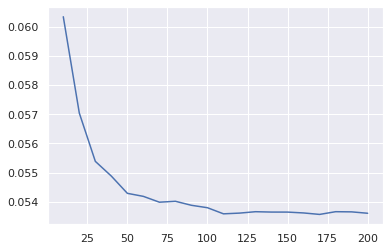

In [17]:
plt.plot(df_scores.n_estimators, df_scores.rmse)

- After which value of `n_estimators` does RMSE stop improving?

- Answer: `150`

**Question 4**

Let's select the best `max_depth`:

- Try different values of `max_depth`: [10, 15, 20, 25].
- For each of these values, try different values of n_estimators from 10 till 200 (with step 10).
- Fix the random seed: `random_state=1`.

In [18]:
#@ TRAINING THE MODEL WITH DEPTH:

scores = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        # print(n)
        rf = RandomForestRegressor(n_estimators=n,
                                   random_state=1,
                                   n_jobs=-1,
                                   max_depth=d)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred)
        # print('val:', rmse)
        scores.append((d, n, rmse))

In [19]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators', 'rmse'])
df_scores.head()

,max_depth,n_estimators,rmse
0,10,10,0.064821
1,10,20,0.063795
2,10,30,0.063233
3,10,40,0.062960
4,10,50,0.062534


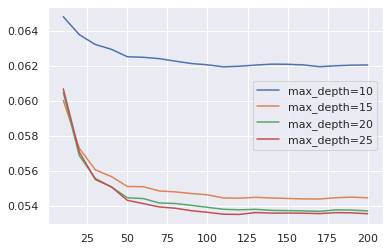

In [20]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label='max_depth=%d' % d)

    plt.legend()

- What's the best `max_depth`:

- Answer:`25`

**Question 5**

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field.

For this homework question, we'll find the most important feature:

Train the model with these parametes:
- `n_estimators=10`,
- `max_depth=20`,
- `random_state=1`,
- `n_jobs=-1` (optional)

Get the feature importance information from this model

Elapsed time to compute the importances: 0.008 seconds
median_income                 0.363326
ocean_proximity=inland        0.310901
latitude                      0.101256
longitude                     0.096470
housing_median_age            0.033145
population                    0.030777
total_rooms                   0.020541
total_bedrooms                0.019172
households                    0.016387
ocean_proximity=near_ocean    0.004699
ocean_proximity=<1h_ocean     0.002489
ocean_proximity=near_bay      0.000480
ocean_proximity=island        0.000357
dtype: float64


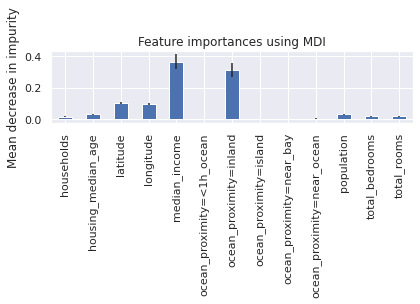

In [21]:
#@ TRAINING THE RANDOM FOREST MODEL:

feature_names=dv.get_feature_names_out().tolist()
# print(feature_names)

rf = RandomForestRegressor(n_estimators=10,
                           max_depth=20,
                           random_state=1,
                           n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
rmse = mean_squared_error(y_val, y_pred)
# print('val:', rmse)

start_time = time.time()
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

# Let’s plot the impurity-based importance

forest_importances = pd.Series(importances, index=feature_names)
print(forest_importances.sort_values(ascending=False))

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

- What's the most important feature?

- Answer: `median_income`

**Question 6**

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost.
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

```
xgb_params = {  
    'eta': 0.3,  
    'max_depth': 6,  
    'min_child_weight': 1,  

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
```



In [22]:
!pip install xgboost

In [23]:
#@ CREATING THE DMARTIX:
features = dv.feature_names_
# print(features)

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [24]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [25]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [37]:
scores = {}

In [41]:
%%capture output

# model with various eta 0.3 and 0.1 ( replace eta value and re-train, output colletced in scores dict)

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [42]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.1'

In [43]:
scores.keys()

dict_keys(['eta=0.3', 'eta=0.1'])

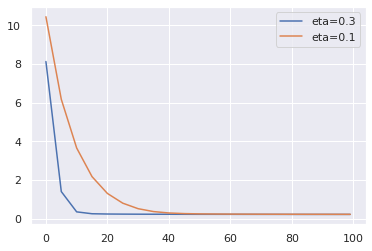

In [44]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=key)
plt.legend()

Now change eta from 0.3 to 0.1.

Which eta leads to the best RMSE score on the validation dataset?

- 0.3
- 0.1
- Both gives same

Answer: `0.3`

In [31]:
######################

- Now, change eta first to 0.1 and then to 0.01.

In [45]:
scores = {}

In [49]:
%%capture output

# model with various eta 0.1 and 0.01 ( replace eta value and re-train, output colletced in scores dict)

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

In [50]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.01'

In [51]:
scores.keys()

dict_keys(['eta=0.1', 'eta=0.01'])

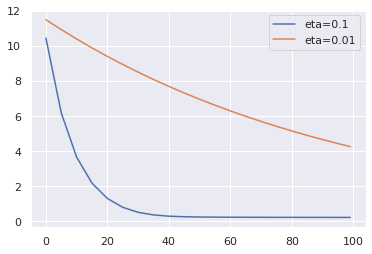

In [52]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=key)
plt.legend()

- Which eta leads to the best RMSE score on the validation dataset?

- Answer: `0.1`